In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *



In [74]:
# VAE model with positions as input to the decoder and softmax output for L_im
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, L_im_dim, position_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder (we concatenate the latent variable z and position)
        self.fc2 = nn.Linear(latent_dim + position_dim, hidden_dim)
        
        # The output layer now needs to have the same dimension as the number of columns in L_im
        self.fc3 = nn.Linear(hidden_dim, L_im_dim)  
        self.softmax = nn.Softmax(dim=1)  # Apply softmax across the columns

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, positions):
        # Ensure positions is of the same dimensionality as z
        if positions.dim() == 1:
            positions = positions.unsqueeze(1)  # Add an extra dimension if needed

        # Concatenate latent variable z with positions
        z_with_positions = torch.cat((z, positions), dim=1)
    
        # Pass through the decoder
        h = F.relu(self.fc2(z_with_positions))
        return self.softmax(self.fc3(h))  # Softmax output matching the dimension of L_im
    
    def forward(self, x, positions):
        mu, logvar = self.encode(x.view(-1, 784))  # MNIST image input flattened
        z = self.reparameterize(mu, logvar)
        return self.decode(z, positions), mu, logvar

class CustomLikelihoodLoss(nn.Module):
    def __init__(self, L_im, epsilon=1e-8):
        super(CustomLikelihoodLoss, self).__init__()
        self.L_im = torch.tensor(L_im, dtype=torch.float32)
        self.epsilon = epsilon  # Small value to avoid log(0)

    def forward(self, pi, mu, logvar, batch_idx, epsilon=1e-5):
        # Select the relevant rows of L_im for the current batch
        L_im_batch = self.L_im[batch_idx]

        # Reconstruction loss (negative log-likelihood)
        inner_sum = torch.sum(pi * L_im_batch, dim=1)
        pi = torch.clamp(pi, min=epsilon)  # Equivalent to tf$maximum(pi, 1e-5)
        log_pi = torch.log(pi)

        # Add L and log(pi)
        combined = L_im_batch + log_pi

        # Compute reduce_logsumexp along the appropriate dimension
        logsumexp_result = torch.logsumexp(combined, dim=1)

        # Sum the result over all batches 
        recon_loss =  -torch.sum(logsumexp_result)

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + kl_div


In [75]:

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
    if is_even:
        return np.random.normal(0, 0.1 + 2 * (np.cos(np.pi * t) ** 2))
    else:
        return np.random.normal(0, 0.1 + 2 * (np.sin(np.pi * t) ** 2))

# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the image and label from MNIST dataset
        image, _ = self.mnist_data[idx]
        
        # Retrieve the corresponding simulated data
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy_value = self.y_noisy[idx]
        digit = self.digits[idx]
        
        return image, digit, position, y_value, y_noisy_value
    
    def get_Lim(self):
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim = get_data_loglik_exp(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            scale=self.scale
        )



In [76]:
# Generate the simulated dataset
n_samples = 50000
noise_level = 0.2
positions = []
y_values = []
digits = []
y_noisy = []

# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 2.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)

positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0])
)


In [77]:

simulated_dataset.get_Lim()
L_im = simulated_dataset.Lim
L_im_dim = L_im.shape[1]
input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
latent_dim = 20
position_dim = 1


In [78]:

# Initialize the model
model = VAE(input_dim, hidden_dim, latent_dim, L_im_dim, position_dim)
criterion = CustomLikelihoodLoss(L_im)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Use the custom simulated dataset with the DataLoader
data_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=True)


In [79]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        optimizer.zero_grad()
        pi, mu, logvar = model(data, positions)
        loss = criterion(pi, mu, logvar, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item() / len(data):.4f}')
    
    print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(data_loader.dataset):.4f}')



Epoch 1, Batch 0, Loss: 2.7168
Epoch 1, Batch 100, Loss: 2.3755
Epoch 1, Batch 200, Loss: 3.0242
Epoch 1, Batch 300, Loss: 2.4156
====> Epoch: 1 Average loss: 2.6302
Epoch 2, Batch 0, Loss: 3.2417
Epoch 2, Batch 100, Loss: 2.5153
Epoch 2, Batch 200, Loss: 2.6335
Epoch 2, Batch 300, Loss: 2.4837
====> Epoch: 2 Average loss: 2.6164
Epoch 3, Batch 0, Loss: 2.5959
Epoch 3, Batch 100, Loss: 2.4006
Epoch 3, Batch 200, Loss: 2.6392
Epoch 3, Batch 300, Loss: 2.6385
====> Epoch: 3 Average loss: 2.6160
Epoch 4, Batch 0, Loss: 2.5107
Epoch 4, Batch 100, Loss: 2.6215
Epoch 4, Batch 200, Loss: 2.4359
Epoch 4, Batch 300, Loss: 2.4856
====> Epoch: 4 Average loss: 2.6164
Epoch 5, Batch 0, Loss: 2.6758
Epoch 5, Batch 100, Loss: 2.6050
Epoch 5, Batch 200, Loss: 2.4334
Epoch 5, Batch 300, Loss: 2.5621
====> Epoch: 5 Average loss: 2.6160
Epoch 6, Batch 0, Loss: 2.6128
Epoch 6, Batch 100, Loss: 3.0939
Epoch 6, Batch 200, Loss: 2.6306
Epoch 6, Batch 300, Loss: 2.4855
====> Epoch: 6 Average loss: 2.6159
Epoc

In [80]:
# Inference to get pi values
model.eval()
fitted_pi_list = []
with torch.no_grad():
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        pi, mu, logvar = model(data, positions)
        fitted_pi_list.append(pi.cpu().numpy())

all_pi_values_np = np.vstack(fitted_pi_list)
print("Shape of all_pi_values_np:", all_pi_values_np.shape)



Shape of all_pi_values_np: (50000, 10)


C:\Users\willi\AppData\Local\Temp\ipykernel_17048\1794910980.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


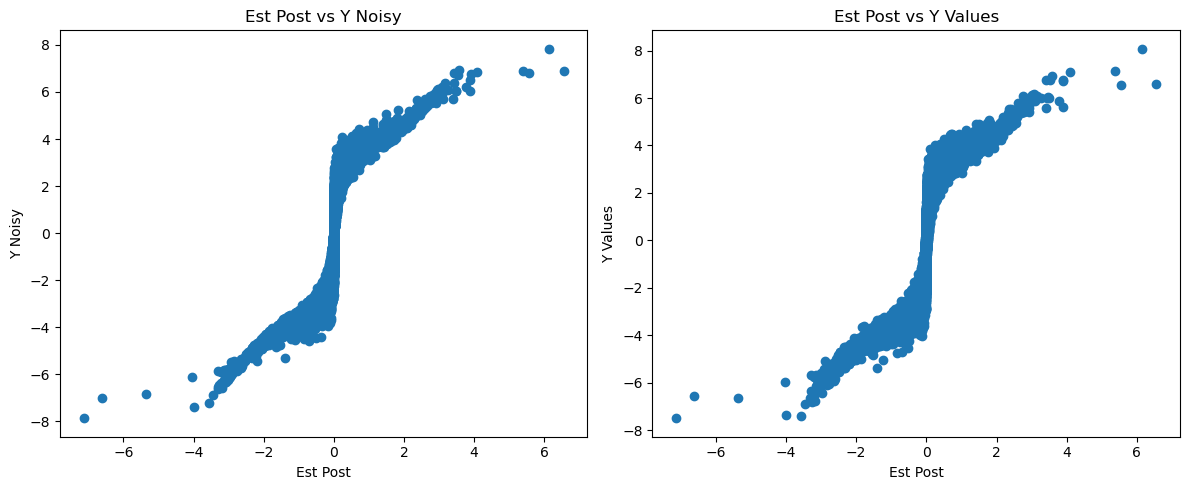

In [81]:
# Post-processing using posterior mean
est_post = np.zeros((all_pi_values_np.shape[0],))

for i in range(all_pi_values_np.shape[0]):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([[y_noisy[i]]]),
        sebetahat=np.array([[1]]),
        log_pi=np.log(np.array(all_pi_values_np[i, :])),
        scale=simulated_dataset.scale
    ).post_mean

plt.figure(figsize=(12, 5))

# Plot est_post vs y_noisy
plt.subplot(1, 2, 1)
plt.scatter(est_post, y_noisy)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')

# Plot est_post vs y_values
plt.subplot(1, 2, 2)
plt.scatter(est_post,noiseless )
plt.title('Est Post vs Y Values')
plt.xlabel('Est Post')
plt.ylabel('Y Values')

plt.tight_layout()
plt.show()


Shape of latent variables (z): (50000, 20)


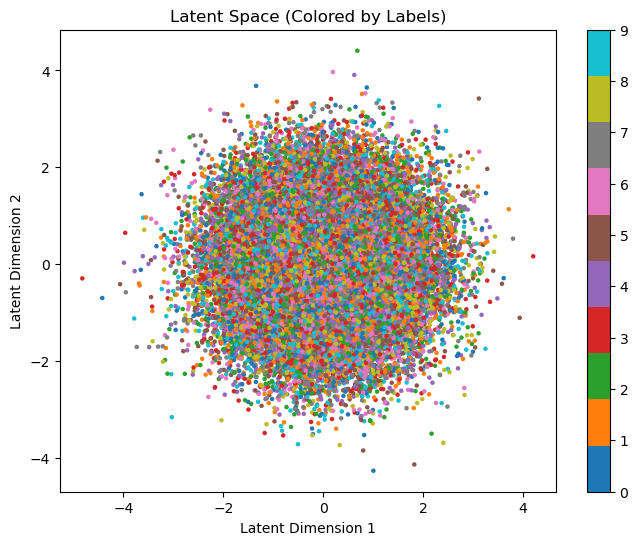

In [82]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize lists to hold latent variables and corresponding labels
all_z = []
all_labels = []

# Disable gradient calculation during inference
with torch.no_grad():
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        
        # Encode the data to get the latent variables
        mu, logvar = model.encode(data.view(-1, 784))  # Flatten the MNIST images
        z = model.reparameterize(mu, logvar)  # Latent variable z
        
        # Append the latent variables and labels
        all_z.append(z)
        all_labels.append(target)
    
    # Concatenate all the latent variables and labels from each batch
    all_z = torch.cat(all_z).cpu().numpy()  # Convert to NumPy array for plotting
    all_labels = torch.cat(all_labels).cpu().numpy()

# Check the shape of the latent variables
print(f"Shape of latent variables (z): {all_z.shape}")

# Plot the latent space using the first two dimensions (assuming z has more than 2 dimensions)
plt.figure(figsize=(8, 6))

if all_z.shape[1] > 1:
    plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=5)
else:
    plt.scatter(all_z[:, 0], [0] * len(all_z), c=all_labels, cmap='tab10', s=5)

plt.colorbar()
plt.title('Latent Space (Colored by Labels)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2' if all_z.shape[1] > 1 else 'Single Dimension')
plt.show()


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# VAE model with positions as input to the decoder and softmax output for L_im
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, L_im_dim, position_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder (we concatenate the latent variable z and position)
        self.fc2 = nn.Linear(latent_dim + position_dim, hidden_dim)
        
        # The output layer now needs to have the same dimension as the number of columns in L_im
        self.fc3 = nn.Linear(hidden_dim, L_im_dim)  
        self.softmax = nn.Softmax(dim=1)  # Apply softmax across the columns

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, positions):
        # Ensure positions is of the same dimensionality as z
        if positions.dim() == 1:
            positions = positions.unsqueeze(1)  # Add an extra dimension if needed

        # Concatenate latent variable z with positions
        z_with_positions = torch.cat((z, positions), dim=1)
    
        # Pass through the decoder
        h = F.relu(self.fc2(z_with_positions))
        return self.softmax(self.fc3(h))  # Softmax output matching the dimension of L_im
    
    def forward(self, x, positions):
        mu, logvar = self.encode(x.view(-1, 784))  # MNIST image input flattened
        z = self.reparameterize(mu, logvar)
        return self.decode(z, positions), mu, logvar

class CustomLikelihoodLoss(nn.Module):
    def __init__(self, L_im, epsilon=1e-8):
        super(CustomLikelihoodLoss, self).__init__()
        self.L_im = torch.tensor(L_im, dtype=torch.float32)
        self.epsilon = epsilon  # Small value to avoid log(0)

    def forward(self, pi, mu, logvar, batch_idx, epsilon=1e-5):
        # Select the relevant rows of L_im for the current batch
        L_im_batch = self.L_im[batch_idx]

        # Reconstruction loss (negative log-likelihood)
        inner_sum = torch.sum(pi * L_im_batch, dim=1)
        pi = torch.clamp(pi, min=epsilon)  # Equivalent to tf$maximum(pi, 1e-5)
        log_pi = torch.log(pi)

        # Add L and log(pi)
        combined = L_im_batch + log_pi

        # Compute reduce_logsumexp along the appropriate dimension
        logsumexp_result = torch.logsumexp(combined, dim=1)

        # Sum the result over all batches 
        recon_loss =  -torch.sum(logsumexp_result)

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss  #+ kl_div

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
    if is_even:
        return np.random.normal(0, 0.1 + 2 * (np.cos(np.pi * t) ** 2))
    else:
        return np.random.normal(0, 0.1 + 2 * (np.sin(np.pi * t) ** 2))

# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the image and label from MNIST dataset
        image, _ = self.mnist_data[idx]
        
        # Retrieve the corresponding simulated data
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy_value = self.y_noisy[idx]
        digit = self.digits[idx]
        
        return image, digit, position, y_value, y_noisy_value
    
    def get_Lim(self):
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim = get_data_loglik_exp(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            scale=self.scale
        )

# Generate the simulated dataset
n_samples = 50000
noise_level = 0.2
positions = []
y_values = []
digits = []
y_noisy = []

# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 2.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)

positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0])
)

simulated_dataset.get_Lim()
L_im = simulated_dataset.Lim
L_im_dim = L_im.shape[1]
input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
latent_dim = 2
position_dim = 1

# Initialize the model
model = VAE(input_dim, hidden_dim, latent_dim, L_im_dim, position_dim)
criterion = CustomLikelihoodLoss(L_im)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Use the custom simulated dataset with the DataLoader
data_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        optimizer.zero_grad()
        pi, mu, logvar = model(data, positions)
        loss = criterion(pi, mu, logvar, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item() / len(data):.4f}')
    
    print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(data_loader.dataset):.4f}')

# Inference to get pi values
model.eval()
fitted_pi_list = []
with torch.no_grad():
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        pi, mu, logvar = model(data, positions)
        fitted_pi_list.append(pi.cpu().numpy())

all_pi_values_np = np.vstack(fitted_pi_list)
print("Shape of all_pi_values_np:", all_pi_values_np.shape)

# Post-processing using posterior mean
est_post = np.zeros((all_pi_values_np.shape[0],))

for i in range(all_pi_values_np.shape[0]):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([[y_noisy[i]]]),
        sebetahat=np.array([[1]]),
        log_pi=np.log(np.array(all_pi_values_np[i, :])),
        scale=simulated_dataset.scale
    ).post_mean

# Plot est_post vs y_noisy and y_values
plt.figure(figsize=(12, 5))

# Plot est_post vs y_noisy
plt.subplot(1, 2, 1)
plt.scatter(est_post, y_noisy)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')

# Plot est_post vs y_values
plt.subplot(1, 2, 2)
plt.scatter(est_post,noiseless )
plt.title('Est Post vs Y Values')
plt.xlabel('Est Post')
plt.ylabel('Y Values')

plt.tight_layout()
plt.show()


Epoch 1, Batch 0, Loss: 1.8541
Epoch 1, Batch 100, Loss: 1.4401
Epoch 1, Batch 200, Loss: 1.6650
Epoch 1, Batch 300, Loss: 1.4788
====> Epoch: 1 Average loss: 1.4812
Epoch 2, Batch 0, Loss: 1.4807
Epoch 2, Batch 100, Loss: 1.4660
Epoch 2, Batch 200, Loss: 1.5167
Epoch 2, Batch 300, Loss: 1.3639
====> Epoch: 2 Average loss: 1.4515
Epoch 3, Batch 0, Loss: 1.3845
Epoch 3, Batch 100, Loss: 1.3087
Epoch 3, Batch 200, Loss: 1.4818
Epoch 3, Batch 300, Loss: 1.4827
====> Epoch: 3 Average loss: 1.4487
Epoch 4, Batch 0, Loss: 1.4662
Epoch 4, Batch 100, Loss: 1.4342
Epoch 4, Batch 200, Loss: 1.3338
Epoch 4, Batch 300, Loss: 1.3450
====> Epoch: 4 Average loss: 1.4468
Epoch 5, Batch 0, Loss: 1.3948
Epoch 5, Batch 100, Loss: 1.3474
Epoch 5, Batch 200, Loss: 1.6366
Epoch 5, Batch 300, Loss: 1.3402
====> Epoch: 5 Average loss: 1.4448
Epoch 6, Batch 0, Loss: 1.3627
Epoch 6, Batch 100, Loss: 1.5385
Epoch 6, Batch 200, Loss: 1.6252
Epoch 6, Batch 300, Loss: 1.6690
====> Epoch: 6 Average loss: 1.4432
Epoc

Shape of latent variables (z): (50000, 2)


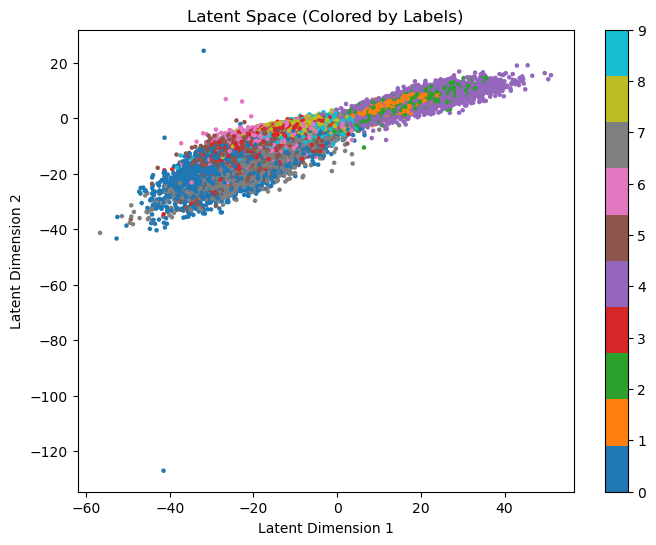

In [72]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize lists to hold latent variables and corresponding labels
all_z = []
all_labels = []

# Disable gradient calculation during inference
with torch.no_grad():
    for batch_idx, (data, target, positions, y_values, y_noisy_values) in enumerate(data_loader):
        
        # Encode the data to get the latent variables
        mu, logvar = model.encode(data.view(-1, 784))  # Flatten the MNIST images
        z = model.reparameterize(mu, logvar)  # Latent variable z
        
        # Append the latent variables and labels
        all_z.append(z)
        all_labels.append(target)
    
    # Concatenate all the latent variables and labels from each batch
    all_z = torch.cat(all_z).cpu().numpy()  # Convert to NumPy array for plotting
    all_labels = torch.cat(all_labels).cpu().numpy()

# Check the shape of the latent variables
print(f"Shape of latent variables (z): {all_z.shape}")

# Plot the latent space using the first two dimensions (assuming z has more than 2 dimensions)
plt.figure(figsize=(8, 6))

if all_z.shape[1] > 1:
    plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=5)
else:
    plt.scatter(all_z[:, 0], [0] * len(all_z), c=all_labels, cmap='tab10', s=5)

plt.colorbar()
plt.title('Latent Space (Colored by Labels)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2' if all_z.shape[1] > 1 else 'Single Dimension')
plt.show()
